In [226]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model

import matplotlib
import matplotlib.pyplot as plt

import glob
import os

%matplotlib inline

In [106]:
cwd = os.getcwd()

SAMPLE_SIZE = 5
IMAGE_PER_SAMPLE = 20
SPLIT_RATIO = 0.7

In [115]:
index = np.arange(SAMPLE_SIZE) + 1
np.random.shuffle(index)

split = (int) (SAMPLE_SIZE * SPLIT_RATIO)
x_train_idx = index[0:split]
x_test_idx = index[split:]

In [233]:
ALL_WORD = ['', 'statement', 'if', 'else', 'elseif', 'for', 'while', 'end']
CHARS_MAP = {v: k for k, v in enumerate(ALL_WORD)}
IDX_MAP = dict(list(enumerate(ALL_WORD)))

def to_onehot(word):
    n_onehot = len(ALL_WORD) - 1
    idx = CHARS_MAP[word]
    if idx == 0:
        return np.zeros(n_onehot)
    else:
        onehot_vec = np.zeros(n_onehot)
        onehot_vec[idx - 1] = 1
        return onehot_vec

def convert_to_feature_list(feature_words):
    onehots = []
    for word in feature_words:
        onehots.append(to_onehot(word))
    return np.array(onehots)
        

def convert_to_input_set(tokens, k):
    n_tokens = len(tokens)
    padded_token = [''] * k + tokens
    res = []
    for i in range(n_tokens - 1):
        res.append((
            convert_to_feature_list(padded_token[i:i + k]),
            to_onehot(padded_token[i + k])
        ))
    return res
        

def input_generator(indexs):
    while(True):
        for idx in indexs:
            picture_files = glob.glob("./data/sample-" + str(idx) + "-*.jpg")
            lang_file = glob.glob('./data/sample-' + str(idx) + '-*.txt')
            
            if len(lang_file) == 0:
                continue
            
            with open(lang_file[0], 'r') as file:
                lang = [l.strip().split(" ")[0] for l in file.read().split("\n") if len(l)]
                lang = list(map(lambda x: "statement" if x.startswith("statement") else x, lang))
            
            embed_lang = convert_to_input_set(lang, 5)
            
            for picture in picture_files:
#                 image = scipy.misc.imread(picture, flatten=True)
#                 image /= 255.0
#                 print(image)
#                 plt.imshow(image)
#                 plt.show()
                    

                x = np.random.rand(1)
                y = (x < 0.5).astype(int)
                yield (x, y)

In [234]:
def generate_model():
    inputs = Input(shape=(1,))

    x = Dense(2, activation='relu')(inputs)
    outputs = Dense(1, activation='relu')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='sgd',
                  loss='mae',
                  metrics=['mae', 'mse'])
    
    print(model.inputs)

    return model

[<tf.Tensor 'input_80:0' shape=(?, 1) dtype=float32>]
Epoch 1/2
[[ 1.          1.          1.         ...,  1.          1.          0.98039216]
 [ 1.          1.          1.         ...,  0.46666667  0.74117649
   0.99607843]
 [ 1.          1.          1.         ...,  0.01176471  0.50980395  1.        ]
 ..., 
 [ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 1.          1.          1.         ...,  1.          1.          1.        ]]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


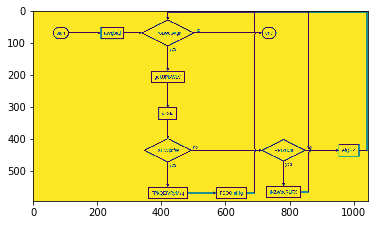

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


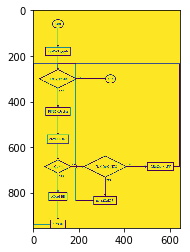

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


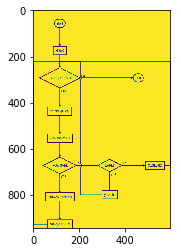

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


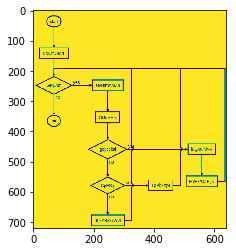

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


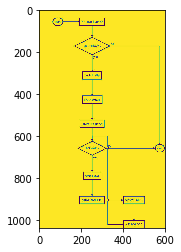

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


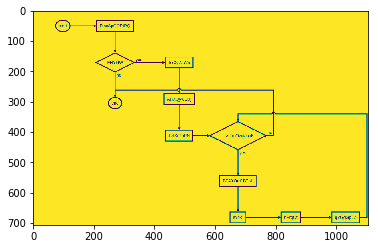

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


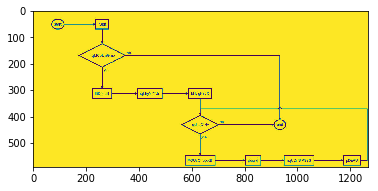

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


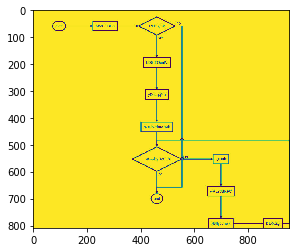

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
1/5 [=====>........................] - ETA: 9s - loss: 1.0000 - mean_absolute_error: 1.0000 - mean_squared_error: 1.0000

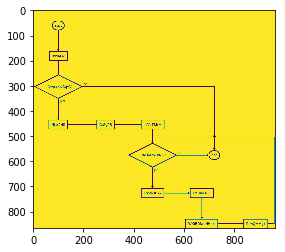

5/5 [==============================] - 2s 456ms/step - loss: 0.6000 - mean_absolute_error: 0.6000 - mean_squared_error: 0.6000
Epoch 2/2
1/5 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - mean_squared_error: 0.0000e+00[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


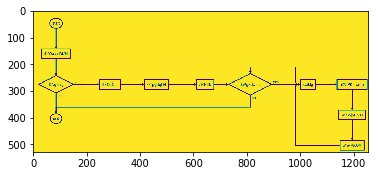

5/5 [==============================] - 0s 50ms/step - loss: 0.6000 - mean_absolute_error: 0.6000 - mean_squared_error: 0.6000       
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


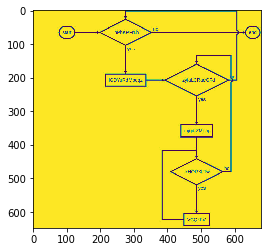

In [235]:
model = generate_model()
model.fit_generator(input_generator(x_train_idx), steps_per_epoch=5, epochs=2)